In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder


from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pickle
import joblib

In [15]:
raw_data = pd.read_csv('./datasets/churn_train.csv')
raw_data.head()

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,2013,6,202550,1835,0,1,9.66,2.26,1,1,...,45.35,0.0,26.62,0.00,390,10,115,10,0.0,0
1,2013,6,930164,536,0,10,54.92,0.60,1,1,...,24.98,0.0,23.90,0.00,52,0,52,0,0.0,0
2,2013,6,46907,1046,0,1,16.25,13.47,1,1,...,116.47,15.2,65.65,31.28,262,0,199,11,0.0,0
3,2013,8,1174456,15947,0,8,0.00,0.00,1,0,...,0.00,0.0,0.00,0.00,0,0,0,0,0.0,0
4,2013,6,300131,1630,0,1,6.14,3.76,1,1,...,30.38,0.0,8.00,0.00,61,0,60,0,0.0,0


**EDA and Feature Selection**

In [30]:
columns = ['user_lifetime', 'user_spendings', 'calls_outgoing_count', 
            'user_no_outgoing_activity_in_days', 'reloads_sum',
            'user_account_balance_last', 'last_100_gprs_usage', 'sms_outgoing_count', 'sms_outgoing_spendings','month', 'churn']

churn_data = raw_data[columns]
churn_data.head()

,user_lifetime,user_spendings,calls_outgoing_count,user_no_outgoing_activity_in_days,reloads_sum,user_account_balance_last,last_100_gprs_usage,sms_outgoing_count,sms_outgoing_spendings,month,churn
0,1835,2.26,40,1,11.92,9.66,0.0,134,0.84,6,0
1,536,0.60,2,10,0.00,54.92,0.0,10,0.60,6,0
2,1046,13.47,45,1,23.01,16.25,0.0,57,4.17,6,0
3,15947,0.00,1,8,0.00,0.00,0.0,0,0.00,8,0
4,1630,3.76,24,1,6.00,6.14,0.0,17,1.55,6,0


In [17]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_lifetime                      60000 non-null  int64  
 1   user_spendings                     60000 non-null  float64
 2   calls_outgoing_count               60000 non-null  int64  
 3   user_no_outgoing_activity_in_days  60000 non-null  int64  
 4   reloads_sum                        60000 non-null  float64
 5   user_account_balance_last          60000 non-null  float64
 6   last_100_gprs_usage                60000 non-null  float64
 7   sms_outgoing_count                 60000 non-null  int64  
 8   sms_outgoing_spendings             60000 non-null  float64
 9   month                              60000 non-null  int64  
 10  churn                              60000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 5.0 MB


In [18]:
churn_data['churn'].value_counts()

churn
0    47451
1    12549
Name: count, dtype: int64

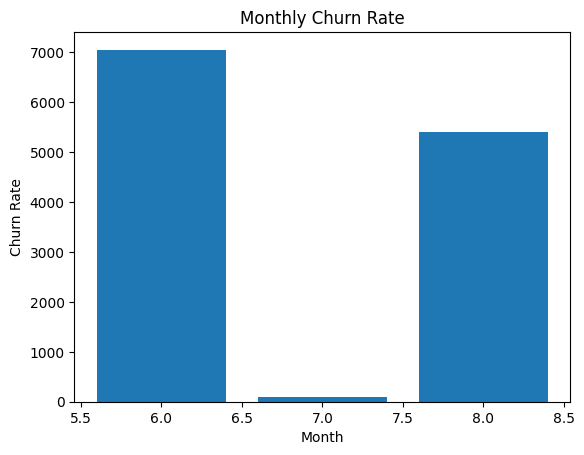

In [19]:
monthly_churn = churn_data.groupby('month').sum('churn').reindex()
plt.bar(monthly_churn['churn'].index, monthly_churn['churn'].values)
plt.title("Monthly Churn Rate")
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.show()

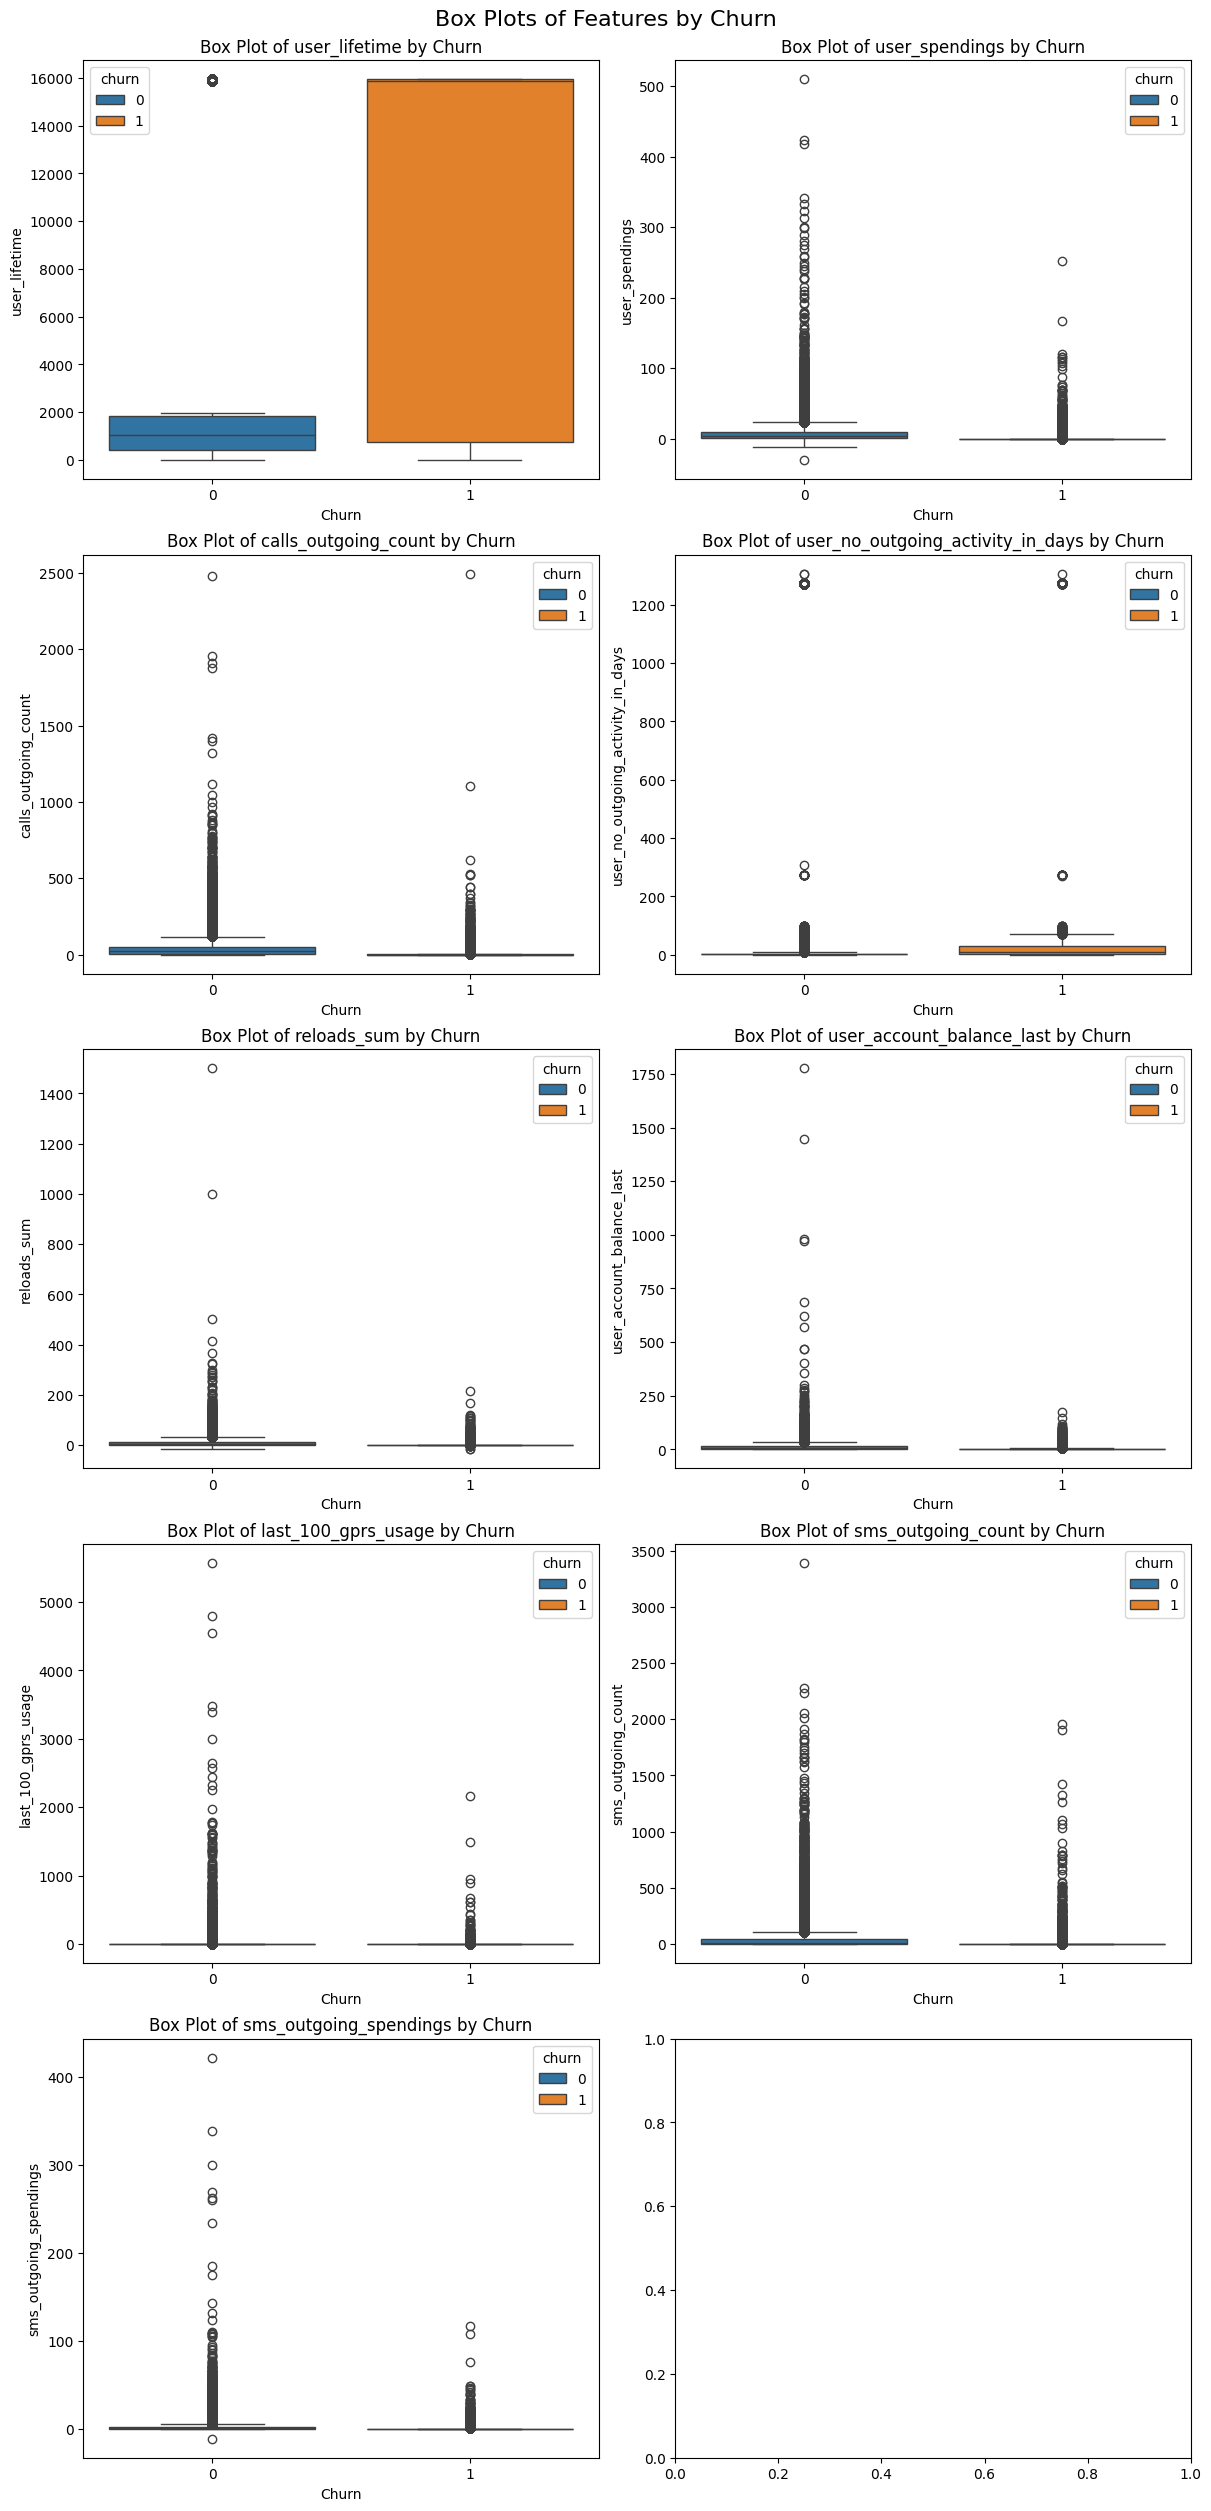

In [20]:
cols = 2  # Number of columns in the subplot grid
num_features = len(columns) -1
rows = (num_features + cols - 1) // cols  # Calculate rows based on features and columns

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5), constrained_layout=True)

# Plot box plots for each feature
for i, feature in enumerate(columns):
    if feature in ('churn', 'month'):
        continue
    ax = axes[i // cols, i % cols]  # Identify the correct subplot position
    sns.boxplot(x='churn', y=feature, data=churn_data, ax=ax, hue='churn')
    ax.set_title(f'Box Plot of {feature} by Churn')
    ax.set_xlabel('Churn')
    ax.set_ylabel(feature)

plt.suptitle('Box Plots of Features by Churn', fontsize=16)
plt.show()

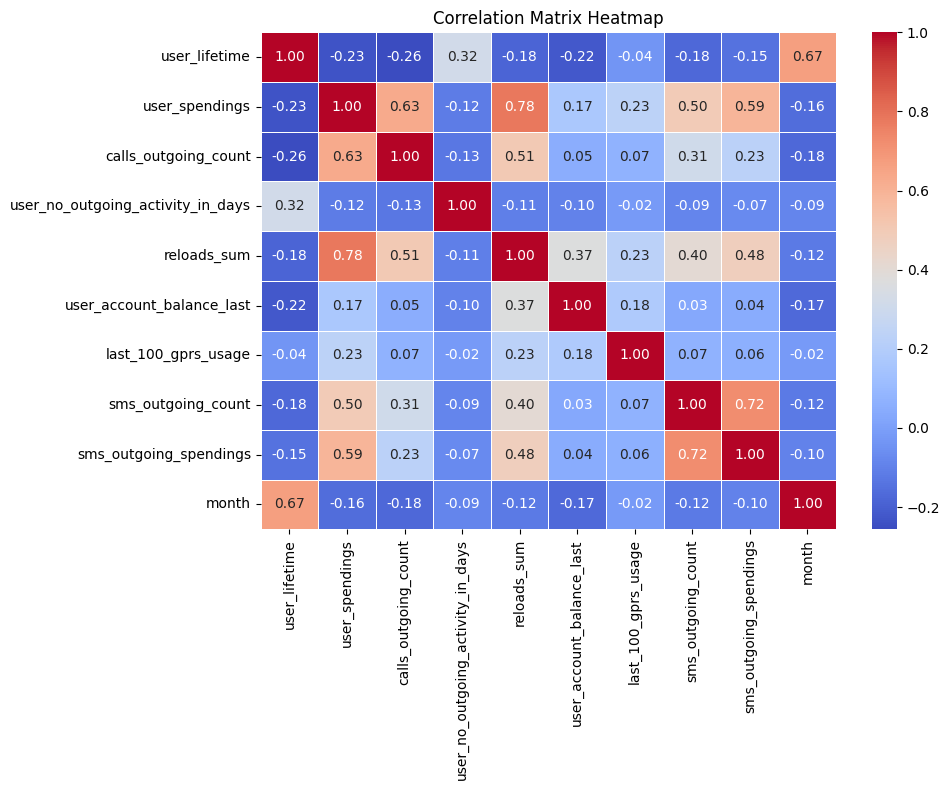

In [21]:
correlation_matrix = churn_data.drop(columns=['churn']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [22]:
selected_columns = ['user_spendings',
                    'month',
'user_lifetime',
'calls_outgoing_count',
'sms_outgoing_count', 
'user_account_balance_last',
'churn']
churn_data = churn_data[selected_columns]


**Prepare data for models**

In [23]:
# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories=[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])  # Use sparse=True for a sparse matrix
encoded = encoder.fit_transform(churn_data[['month']])

# Create a new DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['month']))

# Combine with the original DataFrame if needed
#df_encoded = pd.concat([churn_data, encoded_df], axis=1)
#df_encoded.drop(columns=['month'], inplace=True)


In [24]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to each feature (excluding the label column if there is one)
#churn_data_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

features_without_churn = churn_data.drop(columns=['churn', 'month'])
scaled_df = pd.DataFrame(scaler.fit_transform(features_without_churn), columns=features_without_churn.columns)
X = pd.concat([scaled_df, encoded_df], axis=1)
y =  churn_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True) 

smote = SMOTE(sampling_strategy = 1, random_state=42)
# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

**Training and Model Evaluation**

In [25]:
list_of_models = {
    'logistic_regression' : LogisticRegression(),
    'decision_tree' : DecisionTreeClassifier(),
    'random_forest' : RandomForestClassifier(),
    'GBDT' : GradientBoostingClassifier(),
}


For Model: logistic_regression
Performing Grid Search for logistic_regression...
Best Parameters for logistic_regression: {'C': 100, 'max_iter': 10000, 'solver': 'saga'}
For Test Set:

Macro F1 Score: 0.6618102349298852

Confusion Matrix:


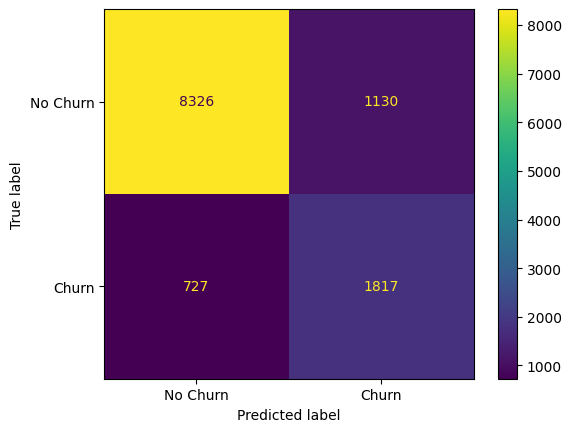


For Model: decision_tree
Performing Grid Search for decision_tree...
Best Parameters for decision_tree: {'criterion': 'entropy', 'max_depth': None}
For Test Set:

Macro F1 Score: 0.6246684350132626

Confusion Matrix:


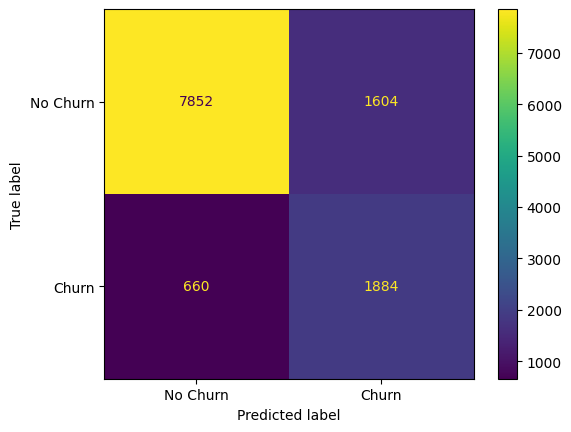


For Model: random_forest
Performing Grid Search for random_forest...
Best Parameters for random_forest: {'max_depth': None, 'n_estimators': 200}
For Test Set:

Macro F1 Score: 0.6821820889964625

Confusion Matrix:


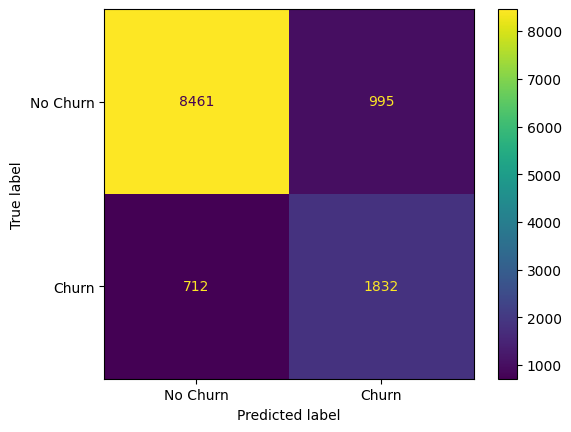


For Model: GBDT
Performing Grid Search for GBDT...
Best Parameters for GBDT: {'max_depth': 5, 'n_estimators': 150}
For Test Set:

Macro F1 Score: 0.6970509383378016

Confusion Matrix:


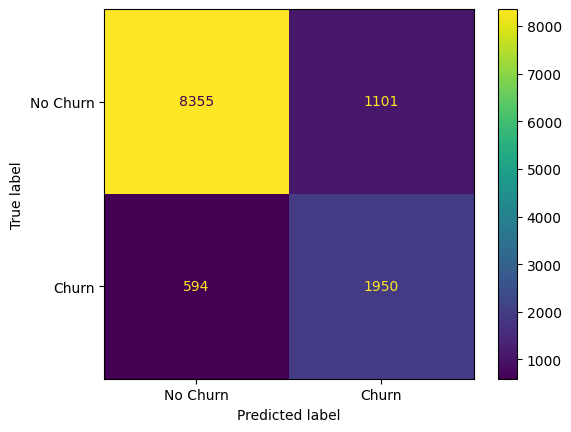

In [26]:
# Hyperparameter grids for GridSearchCV
param_grids = {
    'logistic_regression': {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Solvers
        'max_iter': [10000]
    },
    'decision_tree': {
        'max_depth': [3, 5, 10, None],  # Depth of the tree
        'criterion': ['gini', 'entropy'] # Splitting criteria
    },
    'random_forest': {
        'n_estimators': [50, 100, 200],  # Number of trees
        'max_depth': [4, 6, 10, None]  # Maximum tree depth
    },
    'GBDT': {
        'n_estimators': [50, 100, 150],  # Number of boosting stages
        'max_depth': [3, 4, 5]  # Depth of each estimator

    },
}


precision_test_scores = []
f1_test_scores = []
recall_test_scores = []
trained_models = []

model_names = list_of_models.keys()

for model_name in model_names:
    print("\nFor Model:", model_name)
    
    # Get the model and parameter grid
    model = list_of_models[model_name]
    param_grid = param_grids.get(model_name, {})  # Retrieve parameter grid or empty dict

    # Apply GridSearchCV
    if param_grid:  # Only apply Grid Search if params are defined
        print(f"Performing Grid Search for {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    else:
        print(f"No hyperparameter grid defined for {model_name}. Using default model.")
        best_model = model
        best_model.fit(X_train, y_train)

    print("For Test Set:")

    # Predict using the best model
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    f1_test = f1_score(y_test, y_test_pred, average='binary')
    print("\nMacro F1 Score:", f1_test)

    recall_test_score = recall_score(y_test, y_test_pred, average='binary')
    precision_test_score = precision_score(y_test, y_test_pred, average='binary')

    # Display confusion matrix
    print("\nConfusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["No Churn", "Churn"])
    cm_display.plot()
    plt.show()

    # Append scores
    precision_test_scores.append(precision_test_score)
    f1_test_scores.append(f1_test)
    trained_models.append(best_model)
    recall_test_scores.append(recall_test_score)


In [27]:
result_df = pd.DataFrame()
result_df['model'] = model_names
result_df['f1_score'] = f1_test_scores
result_df['recall'] = recall_test_scores
result_df['precision'] = precision_test_scores
result_df['trained_model'] = trained_models
result_df.sort_values(by="f1_score", ascending=False, inplace=True)
result_df

,model,f1_score,recall,precision,trained_model
3,GBDT,0.697051,0.766509,0.639135,([DecisionTreeRegressor(criterion='friedman_ms...
2,random_forest,0.682182,0.720126,0.648037,"(DecisionTreeClassifier(max_features='sqrt', r..."
0,logistic_regression,0.661810,0.714230,0.616559,"LogisticRegression(C=100, max_iter=10000, solv..."
1,decision_tree,0.624668,0.740566,0.540138,DecisionTreeClassifier(criterion='entropy')


**Save the best model, scaler and the encoder**

In [28]:
model = result_df.loc[result_df.index[0], "trained_model"]
with open('model_churn_analysis.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model for churn analysis saved as model_churn_analysis.pkl")


Model for churn analysis saved as model_churn_analysis.pkl


In [29]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(encoder, 'encoder.pkl')  # Save the encoder for later use

['encoder.pkl']